In [1]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import wf_psf
from tqdm import tqdm
import scipy.interpolate as sinterp


In [2]:

example_cat_path = '/Users/tl/Documents/research/wf-projects/wf-phase-retrieval/data/train_Euclid_res_2000_TrainStars_id_010_8_bins.npy'
example_cat = np.load(example_cat_path, allow_pickle=True)[()]

In [3]:
example_cat.keys()
# Normal cat -> # dict_keys(['stars', 'noisy_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters'])

dict_keys(['stars', 'noisy_stars', 'super_res_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters'])

In [4]:
example_cat['SEDs'].shape

(2000, 350, 2)

In [5]:
print(example_cat['SEDs'].shape)
print(example_cat['super_res_stars'].shape)
print(example_cat['noisy_stars'].shape)
print(example_cat['positions'].shape)

(2000, 350, 2)
(2000, 64, 64)
(2000, 32, 32)
(2000, 2)


In [6]:
# SEDs are normalized 
# sum(SED) = 1
# Wavelengths in nm

In [7]:
# Load stars
starcat_dir = '/Users/tl/Documents/research/COSMOS-Webb/real_data/cats/'
filters_dir = '/Users/tl/Documents/research/COSMOS-Webb/filters/nircam_throughput/mean_throughputs/'

filters_star = ['f115w', 'f150w', 'f277w', 'f444w']
filters_sed = ['F115W', 'F150W', 'F277W', 'F444W']

starcat_paths = [starcat_dir+'mosaic_nircam_{:s}_COSMOS-Web_30mas_v0_1_starcat.fits'.format(filt) for filt in filters_star]
filters_paths = [filters_dir+'{:s}_mean_system_throughput.txt'.format(filt) for filt in filters_sed]




In [8]:
# Define SED support
# print(np.min(SED_datas[0][0,:,0]))
# print(np.max(SED_datas[3][0,:,0]))

# _min_w = np.min(SED_datas[0][0,:,0])
# _max_w = np.max(SED_datas[3][0,:,0])

SED_sampling = 0.001 # in [um]

min_w = 0.969
max_w = 5.198
samp_num = np.int64((max_w - min_w) / SED_sampling)

wav_support = np.linspace(min_w, max_w, num=samp_num, endpoint=False)

wav_support.shape

(4229,)

In [160]:

starcats = []
x_worlds = []
y_worlds = []
SED_datas = []
old_SED_datas = []
stars_list = []

number_samples = 1150

for it in range(len(filters_star)):
    starcat_path = starcat_paths[it]
    filters_path = filters_paths[it]

    # Load star catalogue
    starcats.append(fits.open(starcat_path))
    x_worlds.append(starcats[it][1].data['X_WORLD'])
    y_worlds.append(starcats[it][1].data['Y_WORLD'])
    stars_list.append(starcats[it][1].data['VIGNET'])
    
    # Load filter info
    current_SED = np.genfromtxt(filters_path, delimiter=' ', skip_header=1)
    # old_SED_datas.append(current_SED)
    SED_data = np.zeros((x_worlds[it].shape[0], number_samples, 2))
    new_SED = np.zeros((number_samples, 2))
    # Create interpolator
    SED_interp = sinterp.interp1d(
        current_SED[:, 0], current_SED[:, 1], kind='cubic', bounds_error=False, fill_value="extrapolate"
    )
    wavelengths = np.linspace(start=current_SED[0, 0], stop=current_SED[-1, 0], num=number_samples)
    new_SED[:,0] = np.copy(wavelengths)
    new_SED[:,1] = SED_interp(wavelengths)
    # Define interpolation mask
    # current_mask = (wav_support > current_SED[0,0]) * (wav_support < current_SED[-1,0])
    # new_SED[current_mask,1] = SED_interp(wav_support[current_mask])
    # new_SED[:,0] = np.copy(wav_support)

    for it_j in range(x_worlds[it].shape[0]):
        SED_data[it_j,:,:] = np.copy(new_SED)

    SED_datas.append(SED_data)

    


x_worlds_np = np.concatenate(x_worlds)
y_worlds_np = np.concatenate(y_worlds)
SEDs = np.concatenate(SED_datas)
stars = np.concatenate(stars_list)

# Transform positions
x_min_id = np.argmin(x_worlds_np)
x_1 = x_worlds_np[x_min_id]
y_1 = y_worlds_np[x_min_id]

y_max_id = np.argmax(y_worlds_np)
x_2 = x_worlds_np[y_max_id]
y_2 = y_worlds_np[y_max_id]

x_max_id = np.argmax(x_worlds_np)
x_3 = x_worlds_np[x_max_id]
y_3 = y_worlds_np[x_max_id]

y_min_id = np.argmin(y_worlds_np)
x_4 = x_worlds_np[y_min_id]
y_4 = y_worlds_np[y_min_id]

# Hypotenuse
m = (y_2 - y_1) / (x_2 - x_1)
b = y_1 - x_1 * m

# Mid point
x_mid = np.min(x_worlds_np) + (np.max(x_worlds_np) - np.min(x_worlds_np)) / 2
y_mid = np.min(y_worlds_np) + (np.max(y_worlds_np) - np.min(y_worlds_np)) / 2

# Intersection
y_hyp = y_mid
x_hyp = (y_hyp - b) / m

segment_norm = lambda _x, _y : np.sqrt(_x**2 + _y**2)

opp = segment_norm(x_2 - x_2, y_2 - y_mid)
hyp = segment_norm(x_2 - x_hyp, y_2 - y_hyp)

alpha = np.arcsin(opp/hyp)
theta =  (np.pi/2. - alpha)

# Define rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# Define transformation to positions
pos_x_transform = lambda _x, _y: R[0,0] * (_x - x_mid) + R[0,1] * (_y - y_mid) + x_mid
pos_y_transform = lambda _x, _y: R[1,0] * (_x - x_mid) + R[1,1] * (_y - y_mid) + y_mid
# Apply transformation to positions
rot_x = pos_x_transform(x_worlds_np, y_worlds_np)
rot_y = pos_y_transform(x_worlds_np, y_worlds_np)

# Define scaling to the [0, 1e3] square
pos_lim = 1.e3
scaling_x_transform = lambda _x: (_x - np.min(rot_x)) * (pos_lim / (np.max(rot_x) - np.min(rot_x)))
scaling_y_transform = lambda _y: (_y - np.min(rot_y)) * (pos_lim / (np.max(rot_y) - np.min(rot_y)))

new_x = scaling_x_transform(rot_x)
new_y = scaling_y_transform(rot_y)

transform_x = lambda _x, _y: scaling_x_transform(pos_x_transform(_x, _y))
transform_y = lambda _x, _y: scaling_y_transform(pos_y_transform(_x, _y))

pos = np.concatenate((new_x.reshape(-1,1), new_y.reshape(-1,1)), axis=1)



(1820, 31, 31)

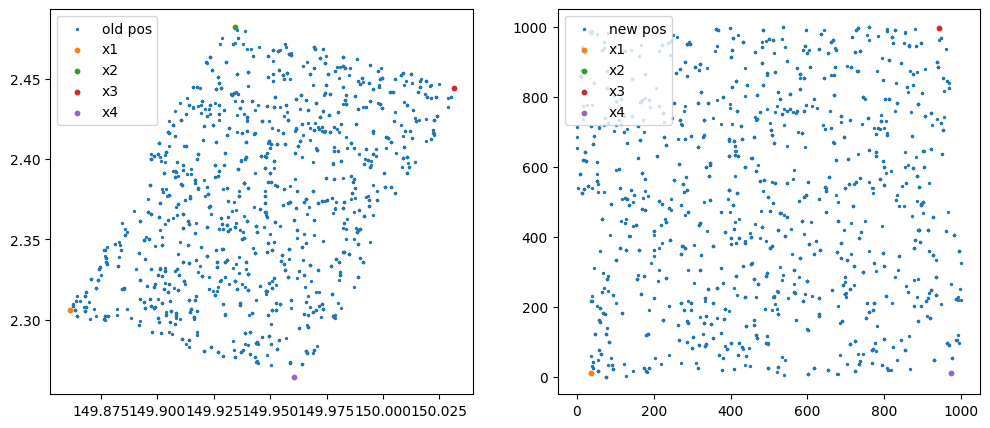

In [162]:
plt.figure( figsize=(12,5))

plt.subplot(121)
plt.scatter(
    x=x_worlds_np,
    y=y_worlds_np,
    s=2,
    label='old pos'
)
plt.scatter(x=x_1,y=y_1,s=10,label='x1')
plt.scatter(x=x_2,y=y_2,s=10,label='x2')
plt.scatter(x=x_3,y=y_3,s=10,label='x3')
plt.scatter(x=x_4,y=y_4,s=10,label='x4')
plt.legend()


plt.subplot(122)
plt.scatter(
    x=new_x,
    y=new_y,
    s=2,
    label='new pos'
)
plt.scatter(transform_x(x_1,y_1), transform_y(x_1,y_1),s=10,label='x1')
plt.scatter(transform_x(x_2,y_2), transform_y(x_2,y_2),s=10,label='x2')
plt.scatter(transform_x(x_3,y_3), transform_y(x_3,y_3),s=10,label='x3')
plt.scatter(transform_x(x_4,y_4), transform_y(x_4,y_4),s=10,label='x4')

plt.legend()
plt.show()


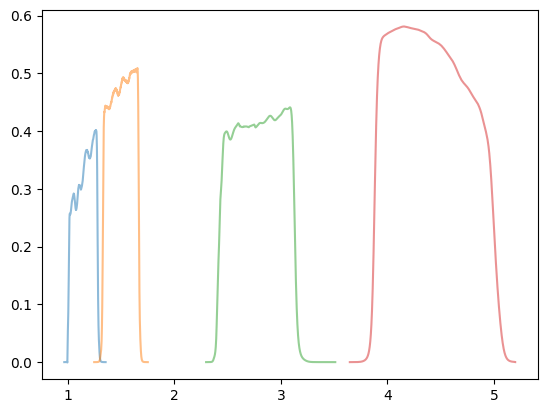

In [163]:
plt.figure()
for it in range(4):
    plt.plot(SED_datas[it][0,:,0], SED_datas[it][0,:,1], alpha=0.5)
plt.show()


In [164]:
print(stars.shape)
print(SEDs.shape)
print(pos.shape)

(1820, 31, 31)
(1820, 1150, 2)
(1820, 2)


In [ ]:
train_psf_dataset = {
    'stars' : poly_psf_np[:n_train_stars, :, :],
    'noisy_stars': noisy_train_stars[:n_train_stars, :, :],
    'positions' : pos_np[:n_train_stars, :],
    'SEDs' : SED_np[:n_train_stars, :, :],
    'parameters': dataset_params
}


In [61]:
samp = SED_datas[0][0,2,0] - SED_datas[0][0,1,0]
print('samp: ', samp)
samp = SED_datas[1][0,2,0] - SED_datas[1][0,1,0]
print('samp: ', samp)
samp = SED_datas[2][0,2,0] - SED_datas[2][0,1,0]
print('samp: ', samp)
samp = SED_datas[3][0,2,0] - SED_datas[3][0,1,0]
print('samp: ', samp)


samp:  0.0010000000000000009
samp:  0.001000000000000112
samp:  0.001200966000000303
samp:  0.0013512310000001193


In [69]:
(5.198 - 0.969) / 0.001


4229.0

In [ ]:
SED_interp = sinterp.interp1d(
            SED[:, 0], SED[:, 1], kind=interp_kind, bounds_error=False, fill_value="extrapolate"
        )

In [83]:
wav_support

array([0.969, 0.97 , 0.971, ..., 5.195, 5.196, 5.197])

In [68]:
(max_w - min_w)/0.001

65.03835277582735

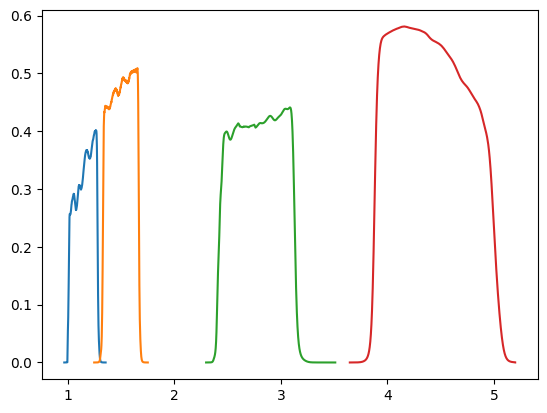

In [58]:
plt.figure()

plt.plot(SED_datas[0][0,:,0], SED_datas[0][0,:,1])
plt.plot(SED_datas[1][0,:,0], SED_datas[1][0,:,1])
plt.plot(SED_datas[2][0,:,0], SED_datas[2][0,:,1])
plt.plot(SED_datas[3][0,:,0], SED_datas[3][0,:,1])
plt.show()


In [35]:



x_worlds_np = np.concatenate(x_worlds)
y_worlds_np = np.concatenate(y_worlds)


In [36]:
x_worlds_np.shape

(1820,)

In [17]:
starcat = fits.open(starcat_paths[0])

In [18]:
# Positions

x_img = starcat[1].data['X_IMAGE']
y_img = starcat[1].data['Y_IMAGE']

x_world = starcat[1].data['X_WORLD']
y_world = starcat[1].data['Y_WORLD']


# Stars
stars = starcat[1].data['VIGNET']



In [19]:
starcat[1].columns

ColDefs(
    name = 'ALPHAWIN_J2000'; format = 'D'; unit = 'deg'; disp = 'F11.7'
    name = 'DELTAWIN_J2000'; format = 'D'; unit = 'deg'; disp = 'F11.7'
    name = 'X_IMAGE'; format = 'E'; unit = 'pix'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = 'E'; unit = 'pix'; disp = 'F11.4'
    name = 'NUMBER'; format = 'J'; disp = 'I10'
    name = 'MAG_ISO'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_ISO'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAG_ISOCOR'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_ISOCOR'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAG_APER'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_APER'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAG_AUTO'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_AUTO'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAG_BEST'; format = 'E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_BEST'; format = 'E'; unit = 'mag'; disp = 'F8.4'
  

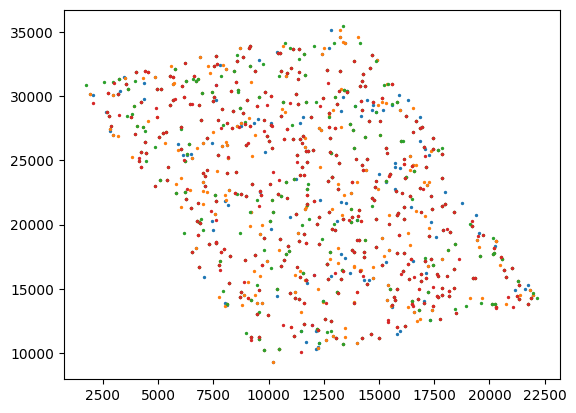

In [27]:

plt.figure()
# plt.scatter()
plt.scatter(
    x=starcats[0][1].data['X_IMAGE'],
    y=starcats[0][1].data['Y_IMAGE'],
    s=2
)
plt.scatter(
    x=starcats[1][1].data['X_IMAGE'],
    y=starcats[1][1].data['Y_IMAGE'],
    s=2
)
plt.scatter(
    x=starcats[2][1].data['X_IMAGE'],
    y=starcats[2][1].data['Y_IMAGE'],
    s=2
)
plt.scatter(
    x=starcats[3][1].data['X_IMAGE'],
    y=starcats[3][1].data['Y_IMAGE'],
    s=2
)
plt.show()

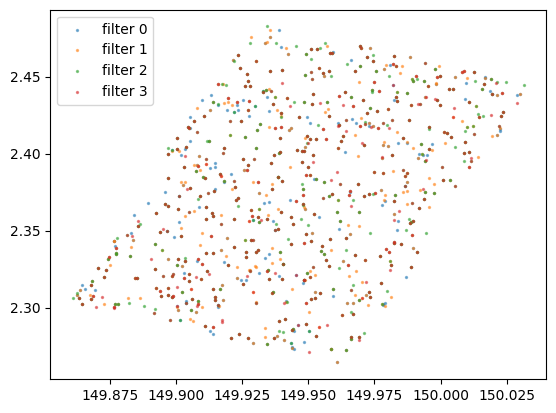

In [62]:
plt.figure()
# plt.scatter()
plt.scatter(
    x=starcats[0][1].data['X_WORLD'],
    y=starcats[0][1].data['Y_WORLD'],
    s=2,
    alpha = 0.5,
    label = 'filter 0'
)
plt.scatter(
    x=starcats[1][1].data['X_WORLD'],
    y=starcats[1][1].data['Y_WORLD'],
    s=2,
    alpha = 0.5,
    label = 'filter 1'
)
plt.scatter(
    x=starcats[2][1].data['X_WORLD'],
    y=starcats[2][1].data['Y_WORLD'],
    s=2,
    alpha = 0.5,
    label = 'filter 2'
)
plt.scatter(
    x=starcats[3][1].data['X_WORLD'],
    y=starcats[3][1].data['Y_WORLD'],
    s=2,
    alpha = 0.5,
    label = 'filter 3'
)
plt.legend()
plt.show()


In [ ]:
# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                 'n_stars':n_test_stars}

# Save dataset C coefficient matrix (reproductible dataset)
C_poly = gen_poly_fieldPSF.C_poly

test_psf_dataset = {'stars' : poly_psf_np[tot_train_stars:, :, :],
                     'positions' : pos_np[tot_train_stars:, :],
                     'SEDs' : SED_np[tot_train_stars:, :, :],
                     'zernike_coef' : zernike_coef_np[tot_train_stars:, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}

np.save(output_folder + 'test_Euclid_res_id_' + dataset_id_str + '.npy',
        test_psf_dataset, allow_pickle=True)



# Save the different train datasets


for it_glob in range(len(n_star_list)):

    n_train_stars = n_star_list[it_glob]

    # Build param dicitionary
    dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                     'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                     'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                     'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                     'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                     'n_stars':n_train_stars}
    
    train_psf_dataset = {'stars' : poly_psf_np[:n_train_stars, :, :],
                     'noisy_stars': noisy_train_stars[:n_train_stars, :, :],
                     'positions' : pos_np[:n_train_stars, :],
                     'SEDs' : SED_np[:n_train_stars, :, :],
                     'zernike_coef' : zernike_coef_np[:n_train_stars, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}
    

    np.save(output_folder + 'train_Euclid_res_' + str(n_train_stars) + '_TrainStars_id_' + dataset_id_str + '.npy',
            train_psf_dataset, allow_pickle=True)

In [3]:

# Paths

# SED folder path
SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/explore_SEDs/save_SEDs/'
# SED_path = '/local/home/tliaudat/data/'

# Output saving path
output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/github/wf-psf/psf-generation/scripts/output/'
# output_folder = '/local/home/tliaudat/psf-datasets/'


# Dataset ID
dataset_id = 1
dataset_id_str = '%03d'%(dataset_id)


# This list must be in order from bigger to smaller
# n_star_list = [2000, 1000, 500, 200]
# n_test_stars = 400  # 20% of the max test stars

n_star_list = [50, 40, 30, 20]
n_test_stars = 10  # 20% of the max test stars



# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True
pupil_diameter = 256




# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=output_Q, output_dim=output_dim, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)



# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)



# Total stars
n_stars = n_star_list[0] + n_test_stars
# Max train stars
tot_train_stars = n_star_list[0]

# Generate all the stars and then go saving different subsets



# Select random SEDs
SED_list = []
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)

    

# First we choose the locations (randomly)
pos_np = np.random.rand(n_stars, 2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]    
    
    
    
# Generate all the polychromatic PSFs
poly_psf_list = []
zernike_coef_list = []

for it in tqdm(range(n_stars)):
    _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[it, 0],
                                                       yv_flat=pos_np[it, 1],
                                                       SED=SED_list[it])

    poly_psf_list.append(_psf)
    zernike_coef_list.append(_zernike)   

    
    
# Generate numpy arrays from the lists
poly_psf_np = np.array(poly_psf_list)
zernike_coef_np = np.array(zernike_coef_list)
SED_np = np.array(SED_list)
    
    
# Generate the noisy train stars

# Copy the training stars
noisy_train_stars = np.copy(poly_psf_np[:tot_train_stars, :, :])
# Generate a dataset with a SNR varying randomly from 10 to 120
rand_SNR = (np.random.rand(noisy_train_stars.shape[0]) * 100) + 10
# Add Gaussian noise to the observations
noisy_train_stars = np.stack([wf_psf.utils.add_noise(_im, desired_SNR=_SNR) 
                              for _im, _SNR in zip(noisy_train_stars, rand_SNR)], axis=0)



# Save only one test dataset

# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                 'n_stars':n_test_stars}

# Save dataset C coefficient matrix (reproductible dataset)
C_poly = gen_poly_fieldPSF.C_poly

test_psf_dataset = {'stars' : poly_psf_np[tot_train_stars:, :, :],
                     'positions' : pos_np[tot_train_stars:, :],
                     'SEDs' : SED_np[tot_train_stars:, :, :],
                     'zernike_coef' : zernike_coef_np[tot_train_stars:, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}

np.save(output_folder + 'test_Euclid_res_id_' + dataset_id_str + '.npy',
        test_psf_dataset, allow_pickle=True)



# Save the different train datasets


for it_glob in range(len(n_star_list)):

    n_train_stars = n_star_list[it_glob]

    # Build param dicitionary
    dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                     'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                     'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                     'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                     'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                     'n_stars':n_train_stars}
    
    train_psf_dataset = {'stars' : poly_psf_np[:n_train_stars, :, :],
                     'noisy_stars': noisy_train_stars[:n_train_stars, :, :],
                     'positions' : pos_np[:n_train_stars, :],
                     'SEDs' : SED_np[:n_train_stars, :, :],
                     'zernike_coef' : zernike_coef_np[:n_train_stars, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}
    

    np.save(output_folder + 'train_Euclid_res_' + str(n_train_stars) + '_TrainStars_id_' + dataset_id_str + '.npy',
            train_psf_dataset, allow_pickle=True)


    

100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


In [18]:
path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/github/wf-psf/psf-generation/scripts/output/'

dataset = np.load(path + 'train_Euclid_res_20_TrainStars_id_001.npy', allow_pickle=True)[()]


In [19]:
dataset['noisy_stars'].shape

(20, 32, 32)

In [20]:
dataset2 = np.load(path + 'train_Euclid_res_30_TrainStars_id_001.npy', allow_pickle=True)[()]



In [21]:

np.sum(dataset['noisy_stars'] - dataset2['noisy_stars'][0:20,:,:])


0.0

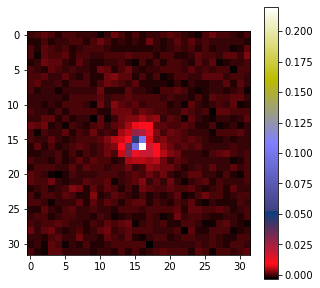

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(dataset['noisy_stars'][18,:,:], cmap='gist_stern');plt.colorbar()
plt.show()